# Lorenzo Cassano lorenzo.cassano2@studio.unibo.it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import pair_confusion_matrix
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

random_state = 42

## 1) Load Data File and Pairplot

In [ ]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files

if IN_COLAB:
    uploaded = google.colab.files.upload()

In [2]:
X_url = 'exam_2021_01_15.csv'
df = pd.read_csv(X_url, sep = ',')

### Separating Y "cluster"

In [3]:
X = df.drop("y", axis= 1)
Y = df["y"]

In [4]:
X.head()

,A0,A1,A2
0,2067.582042,-15.259519,0.020472
1,1319.589579,-18.412320,0.521308
2,1170.212183,-19.470602,0.814986
3,1424.162191,9.867841,0.848751
4,1551.069098,11.809364,0.884964


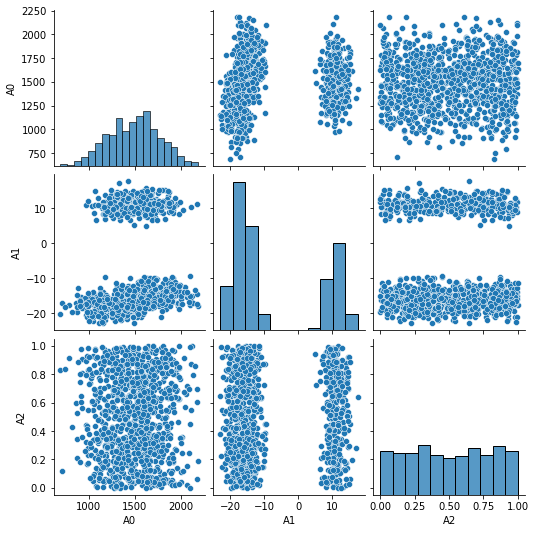

In [67]:
sns.pairplot(X)
plt.show()

We observe that the distributions of values are definitely skewed: in the columns A0 and A1, there are always outliers, frequently in a very large range.

## 2) K-Means Plot of silhouhette and inertia to choose the number of cluster to use

In [68]:
def computing_best_clustering(X, k_range):
  k_range = list(range(2,11)) # set the range of k values to test 
  tuned_param = {'n_clusters' : k_range}
  param = list(ParameterGrid(tuned_param))
  inertias = []
  silhouettes = []

  for i in range(0, len(param)):
    k_model = KMeans(**(param[i]), random_state = random_state)
    y_find = k_model.fit_predict(X)
    silhouette = silhouette_score(X, y_find)
    inertias.append(k_model.inertia_)
    silhouettes.append(silhouette)
  return inertias,silhouettes

In [69]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [70]:
k_range = list(range(2,11))
inertias, silhouettes = computing_best_clustering(X, k_range)

## 2.1 Choice of the number of clusters
The decision of the number of clusters is based on silhouettes and inertia

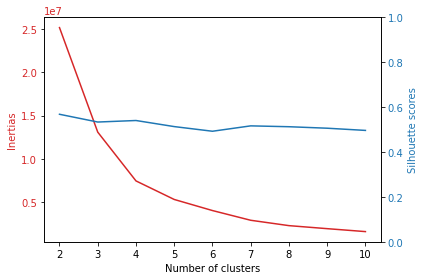

In [71]:
#plt.figure(figsize=(30,30))

two_plots(x=k_range, y1=inertias, y2=silhouettes
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

The two elbow points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=3

## 3) Fit Clustering scheme

In [72]:
k = 3
model =  KMeans(n_clusters= k, random_state = random_state)
y_km = model.fit_predict(X)
print("Number of clusters {}, Distortion {:6.2f}, inertia {:4.2f}".format(k,inertias[k_range.index(k)],silhouettes[k_range.index(k)]))

Number of clusters 3, Distortion 13079861.18, inertia 0.53


## 4 Gold Standard

In [74]:
pcm = pair_confusion_matrix(Y, y_km)
pcm / pcm.sum()

array([[0.47718519, 0.19014815],
       [0.17281481, 0.15985185]])

In [75]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  63.70%


## 5) Possible preprocessing actions
From the previous pariplot is possible to observe that the data  of columns A0 and A1 are in a very large range.
Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:


1.   Computing square root for all the variables
2.   Remap all variable in the range 0:1



In [76]:
# square root transformation - the first two columns are not transformed

X_sqrt = pd.concat([X.iloc[:,:1].applymap(sqrt), X.iloc[:,1:]], axis=1)

# remap on the 0:1 range with MinMaxScaler

minMax = MinMaxScaler()
X_scale = pd.DataFrame(minMax.fit_transform(X_sqrt), columns = X_sqrt.columns)
X_scale.head()

,A0,A1,A2
0,0.937406,0.187350,0.020071
1,0.490706,0.109367,0.521198
2,0.387254,0.083191,0.815046
3,0.559677,0.808861,0.848830
4,0.640060,0.856884,0.885065


## Pairplot with scale data

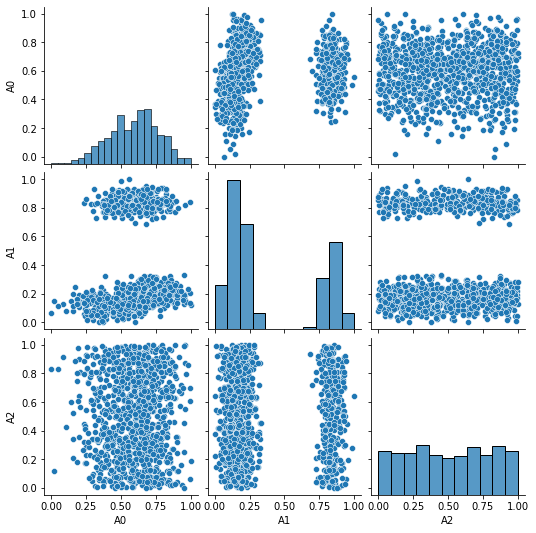

In [77]:
sns.pairplot(X_scale)
plt.show()

In [78]:
inertias, silhouettes = computing_best_clustering(X_scale, k_range)

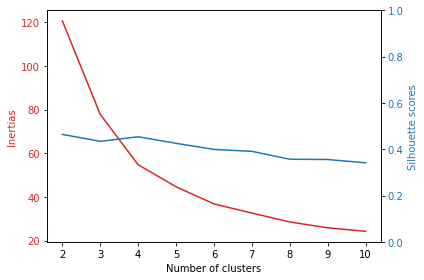

In [79]:
two_plots(x=k_range, y1=inertias, y2=silhouettes
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

For the same previus reasoning we will choose k = 3

In [80]:
best_model =  KMeans(n_clusters= k, random_state = random_state)
y_best = best_model.fit_predict(X_scale)
print("Number of clusters {}, Distortion {:6.2f}, inertia {:4.2f}".format(k,inertias[k_range.index(k)],silhouettes[k_range.index(k)]))

Number of clusters 3, Distortion  77.80, inertia 0.43


In [81]:
pcm = pair_confusion_matrix(Y, y_best)
pcm / pcm.sum()

array([[0.55601802, 0.11131532],
       [0.11117117, 0.2214955 ]])

In [82]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  77.75%


Obviously with a preprocessing there is an improvement of the results